# CA3 - Experiment Design and Hypothesis Testing

In [61]:
# Initial Setup from the BSE introduction practical:

import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random

from BSE import market_session

# The next are helper functions that you will use later, if they don't make 
# much sense now, don't worry too much about it they will become clearer later:

# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_transactions.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_transactions.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_transactions.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')   

Hypothesis - Extending the results of CLiff and Snashall [1]: GDX is more profitable than AA in static markets with periodic replenishment, symmetric supply and demand, populated by an equal proportion AA, GDX, ZIP, PRZI, PRSH, GVWY, SHVR.

Vary supply and demand curves, vary replenishment rate etc.

Reference: Adaptive-Aggressive Traders Don't Dominate, Snashall and Cliff 2019

The hypothesis that I will be investigating aims to extend the results of Cliff and Snashall's 2019 paper: AA Traders Don't Dominate[1], which discovered a number of circumstances where AA was beaten by GDX. My experiment will do this by introducing a wider variety of trading agents into the simulation markets. While their paper investigated a wide variety of market conditions, only two combinations of agents were tried: AA, ASAD, GDX and ZIP, and AA, ASAD, GDX and ZIC. I choose to add some more novel agents, GVWY and SHVR, and assess whether the conclusion is the same. I do not include SNPR as this has previously been shown to perform well in markets populated with few other snipers. 

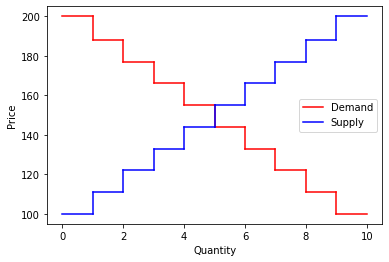

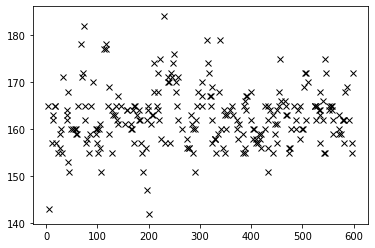

In [67]:
sellers_spec = [("ZIP", 5),("ZIC", 5),("SHVR", 5),("GVWY", 5),("AA",5),("GDX",5)]
buyers_spec = sellers_spec
traders_spec = {"sellers":sellers_spec, "buyers":buyers_spec}

sup_range = (100, 200)
dem_range = (100, 200)

start_time = 0
end_time = 600

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = [{'from':start_time, 'to':end_time, "ranges":[dem_range], "stepmode":"fixed"}]

order_interval = 30
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')


trial_id = 'test_1'
tdump = open('test_1_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_1')

I used the AA implementation from the BSE github and the GDX implmentation from Snashall's code, inserted into the original BSE.

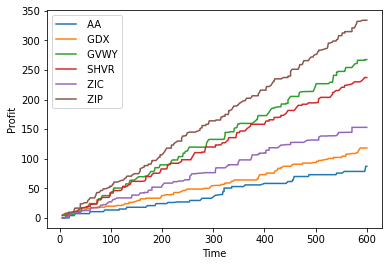

In [68]:
import pandas as pd

trades_df = pd.read_csv('test_1_avg_balance.csv')

fig = plt.figure()
x = trades_df.iloc[:,1]
ax = plt.subplot(111)

for i in range(0,6):
    y = trades_df.iloc[:,4*i+7]

    ax.plot(x,y,label = trades_df.iloc[:,4*i+4][0])

#plt.xlim(0,300)
plt.xlabel('Time')
plt.ylabel('Profit')
ax.legend()
plt.show()

In [101]:
sellers_spec = [("ZIP", 5),("ZIC", 5),("SHVR", 5),("GVWY", 5),("AA",5),("GDX",5)]
buyers_spec = sellers_spec
traders_spec = {"sellers":sellers_spec, "buyers":buyers_spec}

sup_range = (100, 200)
dem_range = sup_range

start_time = 0
end_time = 180

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = supply_schedule

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}

fname = 'balanced_static.csv'

tdump = open(fname, 'w')

tdump.write('%s, %s,%s,%s, ' % ('expid', 'time','best bid','best offer'))
for f in range(6):
        tdump.write('%s, %s, %s, %s, ' % ('type', 'balance', 'number of traders', 'profit per trader'))
tdump.write('%s, %s, ' % ('best bid','best offer'))
tdump.write('\n');

trial = 0
while trial <= 100:
        trial_id = 'trial%04d' % trial
        market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, False, True)
        tdump.flush()
        trial = trial + 1



trial0000;  

trial0001;  

trial0002;  

trial0003;  

trial0004;  

trial0005;  

trial0006;  

trial0007;  

trial0008;  

trial0009;  

trial0010;  

trial0011;  

trial0012;  

trial0013;  

trial0014;  

trial0015;  

trial0016;  

trial0017;  

trial0018;  

trial0019;  

trial0020;  

trial0021;  

trial0022;  

trial0023;  

trial0024;  

trial0025;  

trial0026;  

trial0027;  

trial0028;  

trial0029;  

trial0030;  

trial0031;  

trial0032;  

trial0033;  

trial0034;  

trial0035;  

trial0036;  

trial0037;  

trial0038;  

trial0039;  

trial0040;  

trial0041;  

trial0042;  

trial0043;  

trial0044;  

trial0045;  

trial0046;  

trial0047;  

trial0048;  

trial0049;  

trial0050;  

trial0051;  

trial0052;  

trial0053;  

trial0054;  

trial0055;  

trial0056;  

trial0057;  

trial0058;  

trial0059;  

trial0060;  

trial0061;  

trial0062;  

trial0063;  

trial0064;  

trial0065;  

trial0066;  

trial0067;  

trial0068;  

trial0069;  

trial0070;  

trial

## Statistical testing

Perform a WMW U Test to assess whether GDX or AA performs significantly better than the other 

In [ ]:
import scipy.stats as sp

sp.wilcoxon()

In [102]:
trials_df = pd.read_csv('4_balanced_static.csv')
trials_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '4_balanced_static.csv'